

> L'objectif de ce notebook est de créer un modèle multimodal. 
Les étapes seront les suivantes :
 

*   Notre base de données étant composée de textes et images, et ayant un grand volume, nous allons tout d'abord transformer les données en fichiers TFRecords, il permet de stocker les données en format binaires. ce format a été optimisé pour une lecture efficace et rapide des données par Tensorflow.  
*   A partir de ces fichiers nous créons un objet tf.data.Dataset qui va ous permettre de lire de façon séquentielle les données binaires, leur appliquer un preprocessing et transmettre au modèle de deep learning

*   Nous créons ensuite un modèle qui encode les données images et un autre qui encode les données textes.

*   Puis nous concaténons les représentations obtenues des deux modèles précedents dans un seul modèle "Dual Encoder" . Ce modèle premettra d'apprends des données textes et images à la fois , et ainsi prédire la classe des produits. 
 




In [2]:
#pip install h5py

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
cwd = "/content/drive/My Drive/Rakuten/"
os.chdir(cwd)


os.getcwd()

'/content/drive/My Drive/Rakuten'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import seaborn as sns
from tqdm import tqdm
import random
import cv2
import os
import tensorflow as tf
import nltk
nltk.download("stopwords") 
nltk.download('punkt')
import io, re, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('french'))
from nltk.stem.snowball import FrenchStemmer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Input, Embedding, GlobalAveragePooling1D,  GlobalAveragePooling2D,RNN, GRUCell, LSTM, Dense,Flatten,Concatenate,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
tf.executing_eagerly()
tf.compat.v1.enable_eager_execution() 

from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import seaborn as sns

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Lecture des données CSV et premier preprocessing

Ici nous allons lire les données CSV , comme dans les notebooks précedent afin d'effectuer un premier preprocessing des données textes: Retrait des stopwords, balises html etc.. 

In [15]:
seed=0
test_size=0.1
val_size=0.2
IMG_SIZE = 299 
CHANNELS = 3 
path_to_images="./images/image_train"

In [ ]:
df=pd.read_csv('df.csv')
df.head()

,designation,description,productid,imageid,prdtypecode,image_path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,./images/image_train/image_1263597046_product_...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,./images/image_train/image_1008141237_product_...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,./images/image_train/image_938777978_product_2...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,./images/image_train/image_457047496_product_5...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,./images/image_train/image_1077757786_product_...


In [ ]:
df['class']=df['prdtypecode'].replace(list(df['prdtypecode'].unique()), [i for i in range(27)])
df=df[["designation","image_path","class"]]

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
    
def remplace_accent(x):
    cd=pd.isnull(x)
    if cd==True:
        return x
    accent = ['é', 'è', 'ê', 'à', 'ù', 'û', 'ç', 'ô', 'î', 'ï', 'â','&acirc;','&agrave;','&eacute;','&ecirc;','&egrave;','&euml;','&icirc;','&iuml;','&ocirc;','&oelig;','&ucirc;','&ugrave;','&uuml;','&ccedil;','&lt;','&gt;','&szlig;','&oslash;','&Omega;','&ETH;','&Oslash;','&THORN;','&thorn;','&Aring;']
    sans_accent = ['e', 'e', 'e', 'a', 'u', 'u', 'c', 'o', 'i', 'i', 'a','a','a','e','e','e','e','i','i','o','oe','u','u','u','c',' ',' ','',' ',' ',' ',' ',' ',' ','A']
    for c, s in zip(accent, sans_accent):
        x = x.replace(c, s)
        return x

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w=remplace_accent(w)
    #removing html tags
    w=re.sub('<[^<]+?>', '', w)
    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    #Remove words of length less than 1
    w=re.sub(r'\b\w{,1}\b', '', w)
     # remove stopword
    mots = word_tokenize(w.strip())
    stemmer =  FrenchStemmer()
    mots = [stemmer.stem(mot) for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()
    


df.designation = df.designation.apply(lambda x : preprocess_sentence(x))

In [ ]:
df.head()

,designation,image_path,class
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,./images/image_train/image_1263597046_product_...,0
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,./images/image_train/image_1008141237_product_...,1
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,./images/image_train/image_938777978_product_2...,2
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,./images/image_train/image_457047496_product_5...,3
4,La Guerre Des Tuques,./images/image_train/image_1077757786_product_...,4


# I. Creation des fichiers TFRecords 



## I.1.   Transformation et stockage physique des données binaires



In [ ]:
#dictionnaire dont les clés sont les chemins images et les valeurs sont les données textes

import collections

image_path_to_designation = collections.defaultdict(list)
for designation ,  image_path in zip(df.designation, df.image_path ) :
    designation = designation
    image_path = image_path
    image_path_to_designation[image_path].append(designation)

image_paths = list(image_path_to_designation.keys())
label=df['class'].to_numpy()

In [ ]:
image_paths[0]

'./images/image_train/image_1263597046_product_3804725264.jpg'

In [ ]:
image_path_to_designation[image_paths[0]]

['olivi personalisiert notizbuch seiten punktrast ca din rosen design']



> Pour convertir des données en fichiers TFRecords , nous allons utiliser `tf.train.Example` qui va les sérialiser. Ce dernier prend uniquement 3 types de données (bytes , float64, et int64).

> Nous avons donc besoin de définir le format de sérialisation des données au sérialiseur ci dessus. `tf.train.Feature` permet de le faire, il envoie un protocol message `tf.train.Example` lors de l'enregistrement des données dans le fichier TFRecords.



In [ ]:
# Nous avons besoin de deux formats bytes pour les images et textes et int64 pour les labels

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
# Puis on crée un dictionnaire qui permet d'associer à chaque feature son type et on retourne un objet TF.train.Example
def create_example(image_path, designation, label):
    feature = {
        "designation": bytes_feature(designation.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
        'label': _int64_feature(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



> A present on va écrire les données dans des fichiers TFRecords avec  `tf.io.TFRecordWriter`

In [ ]:

def write_tfrecords(file_name, image_paths, label):
    designation_list = []
    image_path_list = []
    label_list=[]
    for i,image_path in enumerate(image_paths):
        designation = image_path_to_designation[image_path]
        designation_list.extend(designation)
        image_path_list.extend([image_path])
        label_list.append(label[i])

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], designation_list[example_idx],label_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1

### Réglages

>  On crée un dossier "datasets" qui va contenir les fichiers binaires, chaque fichier contient 2000 exemples (image, text, label).  
On split les données train, valid et test sets, les fichiers binaires qui seront stockés auront des préfix "train", "valid" et "test".



In [ ]:


root_dir = "datasets"
tfrecords_dir = os.path.join(root_dir, "tfrecords")
tf.io.gfile.makedirs(tfrecords_dir)

train_size = int(len(df)*0.7)
valid_size = int(len(df)*0.2)+1
test_size = int(len(df)*0.1)
images_per_file = 2000

train_image_paths = image_paths[:train_size]
train_label=label[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-(valid_size+test_size):-test_size]
valid_label=label[-(valid_size+test_size):-test_size]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

test_image_paths = image_paths[-test_size:]
test_label=label[-test_size:]
num_test_files = int(np.ceil(test_size / images_per_file))
test_files_prefix = os.path.join(tfrecords_dir, "test")

print("models directory content:\n", os.listdir("datasets/tfrecords"))

models directory content:
 []


In [ ]:
test_label.shape

(8491,)

Ecriture des données train, valid et test

In [ ]:
#Fonction qui utilise write_tfrecords pour écrire les fichiers de 2000 exemples avec les préfixes correspondants
def write_data(image_paths, label,num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx], label[start_idx:end_idx])
    return example_counter

In [ ]:
train_example_count = write_data(train_image_paths,train_label,num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, valid_label,num_valid_files, valid_files_prefix)
print(f"{valid_example_count} validation examples were written to tfrecord files.")


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
test_example_count = write_data(test_image_paths, test_label,num_test_files, test_files_prefix)
print(f"{test_example_count} test examples were written to tfrecord files.")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.78s/it]

8491 test examples were written to tfrecord files.


## I.2. Création de l'objet `tf.data.Dataset`



> Cette étape va permettre de lire les données par batch à partir des fichiers binaires, et leur appliquer le préporcessing souhaité. 





Import du tokenizer déjà fité sur les données d'entrainement

In [6]:
import pickle
with open('tokenizer_multi_modal.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



> La fonction **read_example** parse les données binaires grâce à `tf.io.parse_single_example` qui leur donne leur type original. Puis elle applique le preprocessing suivant:


1.   Données textes : Tokenise les données string et applique le padding
2.   Données images : resize (299*299*3)
3.   Données labels : One hot Encoding 






In [7]:

root_dir = "datasets"
tfrecords_dir = os.path.join(root_dir, "tfrecords")
maxlen=17
img_size=299
batch_size=128

In [8]:

feature_description = {
        "designation": tf.io.FixedLenFeature([], tf.string),
        "raw_image": tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }


def read_example(example):
    #lecture des 3 features (designation, raw images, et label)
    features = tf.io.parse_single_example(example, feature_description)
    #On retire les raw images, on les décode et resize, puis on les ajoute aux features 
    raw_image = features.pop("raw_image")
    raw_text=features.pop("designation")
    raw_text=raw_text.numpy().decode("utf-8")
    tokenized_text=tokenizer.texts_to_sequences([raw_text])
    sequence=tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, maxlen=maxlen, padding='post')[0]
    label = features.pop("label")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(img_size, img_size)
    )
    features["designation"] = sequence
    features["label"] = tf.one_hot(label, depth=27)
    
    return features

# Les deux fonction ci dessous permettent d'utiliser .numpy() dans la fonction précedente 
def py_func(x):
    d = read_example(x)
    return list(d.values())

def ds_map_fn(x):
    flattened_output = tf.py_function(py_func, [x], [tf.float32,tf.int32,tf.float32])
    return {"image": flattened_output[0], "designation": flattened_output[1],"label": flattened_output[2]}



In [9]:
#Utilisation de read_example pour generer des batch de données 
def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(ds_map_fn,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        .batch(batch_size)
    )



> Nous pouvons ainsi créer les trois `Dataset` objets d'entrainement , validation et test 



In [10]:
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)

In [11]:
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)


In [12]:
test_dataset = get_dataset(os.path.join(tfrecords_dir, "test-*.tfrecord"), batch_size)



> Verification du décodage des données sur les trois sets

In [ ]:
#Verif pour les label
for record in test_dataset:
    print("shape labels: ", record['label'].shape)
    print("First label : ", record['label'][0])
    break

shape labels:  (128, 27)
First label :  tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(27,), dtype=float32)


In [ ]:
#Verif format image
for record in train_dataset:
    print(record['image'].shape)
    break

(128, 299, 299, 3)


In [ ]:
# verif tokenisation de la colonne designation
for record in valid_dataset:
    print("shape des tokens", record['designation'].shape)
    print(record['designation'])
    break

shape des tokens (128, 17)
tf.Tensor(
[[  540   827  6300 ...     0     0     0]
 [   38  2571  8734 ...  2265 12527  4891]
 [   67  2294   187 ... 17257  1933 33963]
 ...
 [ 5245  1117   181 ...     0     0     0]
 [    4   775   636 ...     0     0     0]
 [  797  1126  1235 ...     0     0     0]], shape=(128, 17), dtype=int32)


# II. Céation des modèles

In [13]:
from tensorflow.keras.layers import Dropout, Input, Embedding, GlobalAveragePooling2D, RNN, GRUCell, LSTM, Dense,Flatten,concatenate
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras import callbacks
from datetime import datetime
tf.executing_eagerly()

True

## II.1. Image encoders

Nous nous sommes ineterssés à 3 modèles : 


*   VGG16 , Un réseau de convolution classique , utilisé également dans le notebook classification image
*   Xception qui utilse plusieurs techniques d'amélioration de preformances, comme les "Depthwise Separable Convolution" qui sont des convolutions optimisées pour le calcul (filtres appliqués d'abord par channel séparément puis une conv 1*1 pour regrouper les informations des channels), les connexions ResNet qui peremttent d'apprendre en profondeur en évitant le vanishing gradient. Ce modèle surperforme VGG16 , ResNet et Inception dans l'état de l'art. 
 
*   MobileNet qui est une version otpimisée de Xception (plus rapide), créé par Google, pourles applications mobiles.




[Article interessant sur ces trois modèles](https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41)




In [16]:
def image_Xception(projection_dims, dropout_rate, trainable=False,seed=seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = tf.keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
    
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    
    embeddings = xception(xception_input)
    # Entrainement des top layers
   
    x = Dense(units=projection_dims,activation='relu')(embeddings)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(128,activation='relu')(x)

    # Create the vision encoder model.
    model=Model(inputs, outputs, name="vision_encoder")
    model.summary()
    return model



In [17]:
def image_MobileNet(projection_dims, dropout_rate, trainable=False,seed=seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Load the pre-trained Xception model to be used as the base encoder.
    MobileNetV2 = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in MobileNetV2.layers:
    
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    mobilenet_input = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    
    embeddings = MobileNetV2(mobilenet_input)
    # Entrainement des top layers
   
    x = Dense(units=projection_dims,activation='relu')(embeddings)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(128,activation='relu')(x)

    # Create the vision encoder model.
    model=Model(inputs, outputs, name="image_MobileNet_encoder")
    model.summary()
    return model



In [18]:
def image_vgg16(projection_dims, dropout_rate, trainable=False,seed=seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Load the pre-trained vgg16 model to be used as the base encoder.
    vgg16=tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False)
    # Set the trainability of the base encoder.
    for layer in vgg16.layers:
    
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    vgg16_input = tf.keras.applications.vgg16.preprocess_input(inputs)
    # Generate the embeddings for the images using the vgg16 model.
    
    embeddings = vgg16(vgg16_input)

    # Entrainement des top layers
    x=GlobalAveragePooling2D()(embeddings)
    x = Dense(units=projection_dims,activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(128,activation='relu')(x)
       
   
    # Create the vision encoder model.
    model=Model(inputs, outputs, name="vision_encoder_vgg16")
    model.summary()
    return model



In [19]:
image_MobileNet=image_MobileNet( projection_dims=256, dropout_rate=0.3)

9412608/9406464 [==============================] - 0s 0us/step
Model: "image_MobileNet_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
______________________________________________

In [20]:
image_vgg16=image_vgg16( projection_dims=256, dropout_rate=0.3)

58892288/58889256 [==============================] - 0s 0us/step
Model: "vision_encoder_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 299, 299, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_______________________________________________

In [21]:
image_Xception=image_Xception( projection_dims=256, dropout_rate=0.3)

83689472/83683744 [==============================] - 1s 0us/step
Model: "vision_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_____________________________________________________

## II.2 Texte encoders



> Nous avons deux modèles pour encoder les données textes :
* Un modèle Bi_LSTM, c'est le méilleur modèle obtenu lors de l'entrainnement sur les données textes uniquement
* Un tranfer Learning depuis le modèle Bert (mais ce fut uniquement un test)



In [23]:
#pip install tensorflow_addons

In [24]:

import tensorflow_addons as tfa

In [25]:
embedding_dim = 256
voc_size_inp = len(tokenizer.word_counts)+1
shape=maxlen

In [76]:
def text_bi_lstm( shape, embedding_dim,voc_size_inp,projection_dims, dropout_rate, seed=seed, training=False):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    inputs = Input(shape=shape, dtype='int32', name='text_input')
    text_embedding = Embedding(voc_size_inp, embedding_dim)(inputs)
    x = Bidirectional(LSTM(100, return_sequences=True))(text_embedding)
    x=Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(100))(x)
    x=Dropout(dropout_rate)(x)
   

    # Entrainement des top layers
    x=Flatten()(x)
    #x = Dense(units=projection_dims,activation='relu')(x)
    #x = Dropout(dropout_rate)(x)
    outputs = Dense(128,activation='relu')(x)
       
   
    # Create the vision encoder model.
    model=Model(inputs, outputs, name="text_bi_lstm")
    model.summary()
    return model



In [77]:
text_bi_lstm=text_bi_lstm(shape, embedding_dim,voc_size_inp, projection_dims=128, dropout_rate=0.3)

Model: "text_bi_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 17)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 17, 256)           9760768   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 17, 200)           285600    
_________________________________________________________________
dropout_17 (Dropout)         (None, 17, 200)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 200)              

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
def text_encoder( projection_dims, dropout_rate, trainable=False):
    # Load the BERT preprocessing module.
   
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        "bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    
    model= Model(inputs, outputs, name="text_encoder")
    model.summary()
    return model


In [ ]:
text_encoder = text_encoder( projection_dims=256, dropout_rate=0.1)

Model: "text_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
text_preprocessing (KerasLayer) {'input_word_ids': ( 0           text_input[0][0]                 
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 28763649    text_preprocessing[0][0]         
                                                                 text_preprocessing[0][1]         
                                                                 text_preprocessing[0][2]         
_______________________________________________________________________________________

## II.3. Dual Encoder



> Nous avons créé un modèle customisé qui prend en entrée les deux modèles créés ci dessus, concatene les représentations textes et images, s'entraine sur ces deux données , et prédit la classe des produits.

> A NOTER : Dans ce notebook il y a uniquement l'entrainement du modèle qui prend en entrée [MobileNet et Bi_LSTM], il y a également le résultat de [Xception, Bert] mais ce modèle n'a pas donné de bonnes performances (étant donné qu'il preprocess les données texte en anglais, c'était uniquement un test)

 
> Le Dual Encoder ici applique directement une couche dense la concaténation des embeddings images et textes. 

> J'ai entrainé sur un autre notebook un Dual Encoder avec deux couches denses, et avec [Xception et Bi_LSTM] mais l'entrainement s'est arrêté (déconnexion colab) et je n'ai pas pu récupérer le résultats avec les checkpoints. Compte tenu des deadlines et du manque de ressources, on se contentera pour l'instant du  [MobileNet et Bi_LSTM]




> Nous avons effectué l'entrainement grâce à la loss F1 définit dans les deux notebook précédent, un entrainement sur la loss Categorical crossentropy a donné de moins bon résultats




In [93]:

class DualEncoder(tf.keras.Model):
  # Permet de hériter de la classe Model
    def __init__(self, text_encoder, image_encoder, **kwargs):
        
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.dual_dropout = tf.keras.layers.Dropout(0.3)
        self.dual_dense = tf.keras.layers.Dense(27, activation='softmax')
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.f1_score=tfa.metrics.F1Score(num_classes=27, average='macro', name="f1_score")
        self.accuracy=tf.keras.metrics.CategoricalAccuracy(name='accuracy')
   


    @property 
    def metrics(self):
      # On liste les metriques utilisées pour que reset_states 
      # puisse être appelé automatiquement au début de chaque epoch 
      return [self.loss_tracker, self.accuracy, self.f1_score]
    
    

    #Dans call on définit les inputs des deux encoders , on appelle les deux encoders qui retournent des embeddings text et images
    # On applique un dual entrainement sur les deux embeddings et on output le résultat
    def call(self, features, training=False):
       # embeddings texte.
       text_embeddings = self.text_encoder(features["designation"], training=training)
       #embeddings  images.
       image_embeddings = self.image_encoder(features["image"], training=training)
       dual_embeddings = concatenate([image_embeddings,text_embeddings])
       
       x=self.dual_dropout(dual_embeddings)
       x=self.dual_dense(x)
       return x

    def loss_macro_soft_f1(self, y, y_hat):
      # Definition de la loss macro F1
      y = tf.cast(y, tf.float32)
      y_hat = tf.cast(y_hat, tf.float32)
      tp = tf.reduce_sum(y_hat * y, axis=0) # on multiplie la proba prédite d'un classe (y_hat) par son label=> Uniquement les proba des vrai positifs seront non nuls
      fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
      fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
      soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16) #  calcul du F1 score , 1e-16 pour ne pas diviser par 0
      cost = 1 - soft_f1 # comme on cherche a maximiser F1_score , et qu'il nous faut une fonction coût à minimiser duce 1 - soft-f1 in order to increase soft-f1
      macro_cost = tf.reduce_mean(cost) # on fait la moyenne pour tous les labels du batch
      return macro_cost

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(features, training=True)
            loss = self.loss_macro_soft_f1(features['label'], predictions)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        self.accuracy.update_state(features['label'], predictions)
        self.f1_score.update_state(features['label'], predictions)
        return {"loss": self.loss_tracker.result(),"accuracy": self.accuracy.result(),"f1_score": self.f1_score.result()}

    def test_step(self, features):
        x = self(features, training=False)
        loss = self.loss_macro_soft_f1(x, features['label'])
        self.loss_tracker.update_state(loss)
        self.accuracy.update_state(features['label'], x)
        self.f1_score.update_state(features['label'], x)
        return {"loss": self.loss_tracker.result(),"accuracy": self.accuracy.result(),"f1_score": self.f1_score.result()}

    def get_config(self):
        return {"text_encoder": self.text_encoder, "image_encoder": self.image_encoder}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


## II.4. Entrainement et résultat du Dual Encoder [MobileNet, BiLSTM]

In [27]:
total_size=84916
train_size = int(total_size*0.7)
valid_size = int(total_size*0.2)+1
test_size = int(total_size*0.1)
batch_size=128
num_epochs = 20


Definition des callbacks pour enregistrer les checkpoints, reduire le learning rate si besoin, et arreter l'apprentissange si la val_loss stagne 

In [95]:
checkpoint_path="checkpoints/mobilenetBiLstm"
cp_callbacks=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, verbose=2
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

In [28]:
print("Nombre de batch dans l'ensemble d'entrainement : ", train_size // batch_size)
print("Nombre de batch dans l'ensemble de validation : ", valid_size // batch_size)

Nombre de batch dans l'ensemble d'entrainement :  464
Nombre de batch dans l'ensemble de validation :  132


In [98]:
dual_encoder = DualEncoder(text_bi_lstm, image_MobileNet)

#dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001), loss=macro_soft_f1)
dual_encoder.compile(optimizer="nadam")

In [99]:
history = dual_encoder.fit(
    train_dataset,
    #steps_per_epoch=train_size // batch_size,
    epochs=num_epochs,
    validation_data=valid_dataset,
    #validation_steps=valid_size // batch_size,
    callbacks=[reduce_lr, early_stopping,cp_callbacks],
)

Epoch 1/20
465/465 [==============================] - 553s 1s/step - loss: 0.6373 - accuracy: 0.5021 - f1_score: 0.4203 - val_loss: 0.5230 - val_accuracy: 0.5932 - val_f1_score: 0.5310

Epoch 00001: val_loss improved from inf to 0.52299, saving model to checkpoints/mobilenetBiLstm
Epoch 2/20
465/465 [==============================] - 514s 1s/step - loss: 0.4858 - accuracy: 0.6368 - f1_score: 0.5794 - val_loss: 0.4550 - val_accuracy: 0.6663 - val_f1_score: 0.6153

Epoch 00002: val_loss improved from 0.52299 to 0.45498, saving model to checkpoints/mobilenetBiLstm
Epoch 3/20
465/465 [==============================] - 514s 1s/step - loss: 0.4187 - accuracy: 0.6985 - f1_score: 0.6515 - val_loss: 0.4191 - val_accuracy: 0.6999 - val_f1_score: 0.6473

Epoch 00003: val_loss improved from 0.45498 to 0.41911, saving model to checkpoints/mobilenetBiLstm
Epoch 4/20
465/465 [==============================] - 522s 1s/step - loss: 0.3758 - accuracy: 0.7394 - f1_score: 0.6961 - val_loss: 0.3972 - val_a



> Affichage de l'history du modèle



In [100]:
def learning_curves(history, title="resultat"):
        
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    
    epochs = len(loss)
    

    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(20, 16))

    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs+1), loss, color='b',label='Training Loss', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_loss, color='r',label='Validation Loss', linewidth=2.5)
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs+1), acc, color='b',label='Training accuracy', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_acc, color='r',label='Validation val_accuracy', linewidth=2.5)
    plt.legend(loc='lower right')
    plt.ylabel('accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')

    
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs+1), f1, color='b',label='Training  F1 score', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_f1, color='r',label='Validation macro F1 score', linewidth=2.5)
    plt.legend(loc='lower right')
    plt.ylabel('macro F1')
    plt.title('Training and Validation accuracy')

    plt.xlabel('epoch')
    plt.suptitle(title)

    plt.show()
    
    

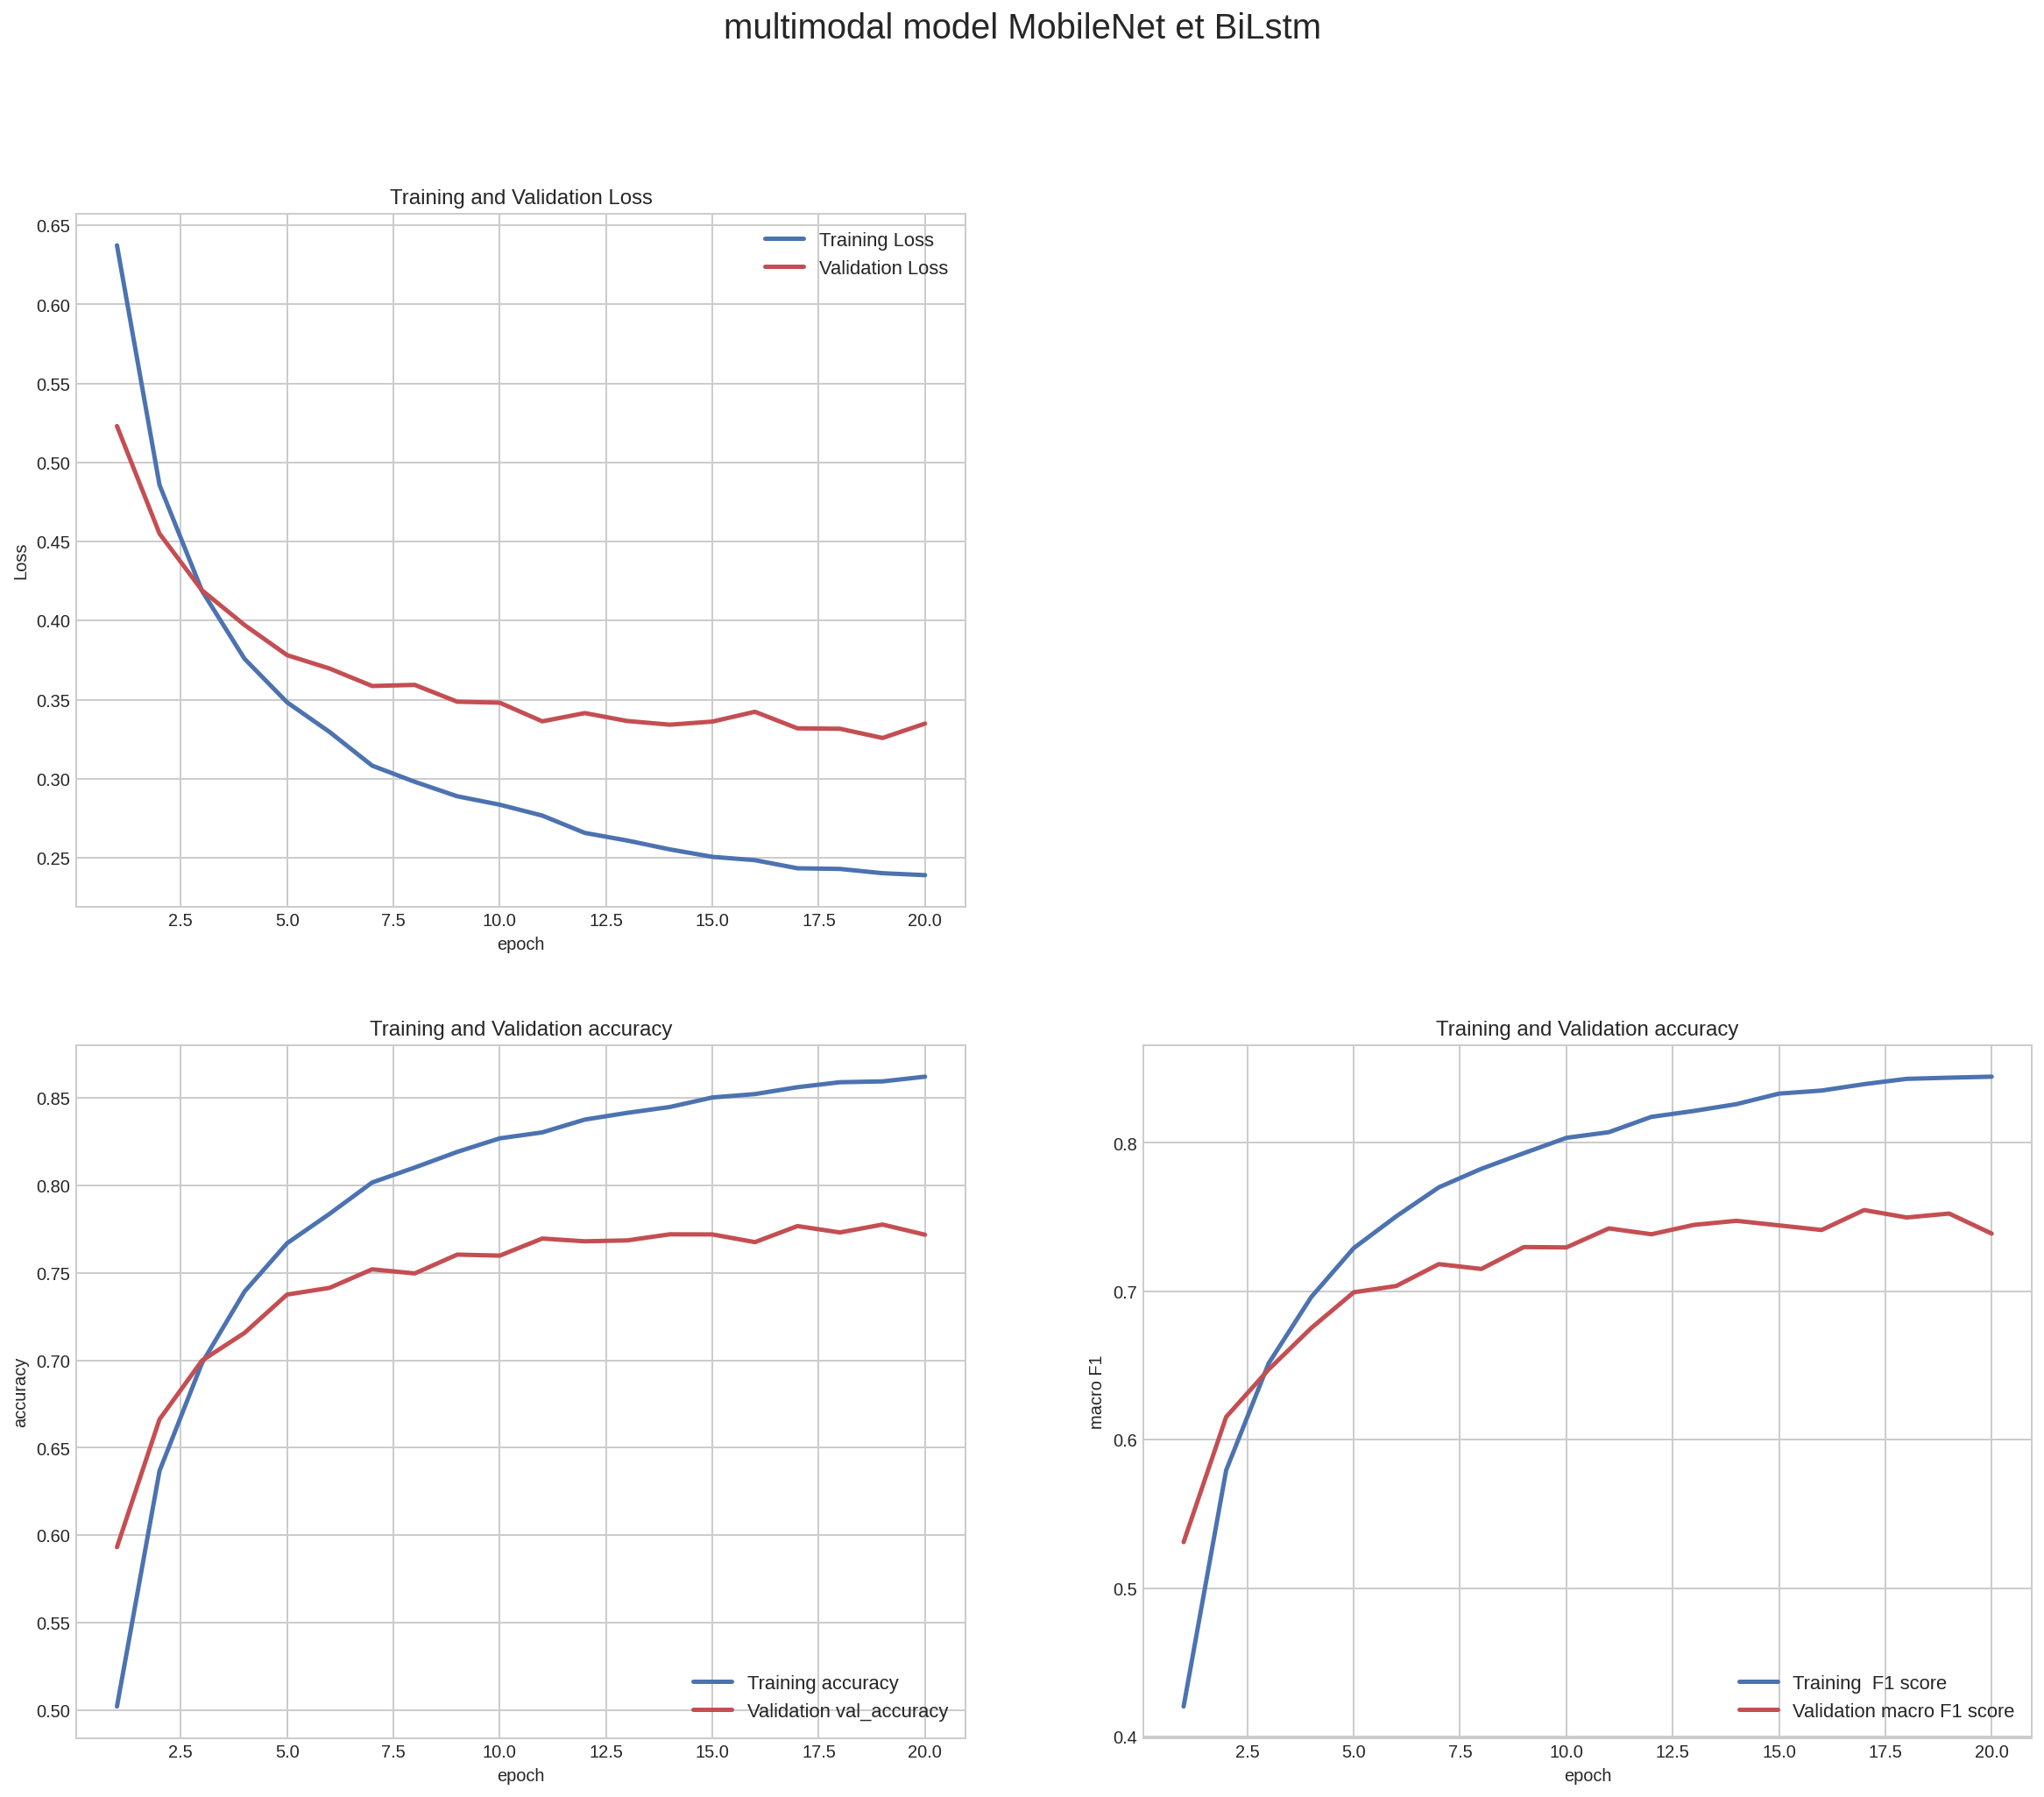

In [101]:
learning_curves(history, "multimodal model MobileNet et BiLstm")



> Prédiction



In [113]:
loss, accuracy, f1 = dual_encoder.evaluate(train_dataset, verbose=False)
print("Training Accuracy: {:.4f} _ Training F1 macro : {:.4f} ".format(accuracy, f1))
loss, accuracy, f1 = dual_encoder.evaluate(valid_dataset, verbose=False)
print("Validation Accuracy: {:.4f} _ Validation F1 macro : {:.4f} ".format(accuracy, f1))
loss, accuracy, f1 = dual_encoder.evaluate(test_dataset, verbose=False)
print("Testing Accuracy:  {:.4f} _ Testing F1 macro : {:.4f} ".format(accuracy, f1))

Training Accuracy: 0.8690 _ Training F1 macro : 0.8495 
Validation Accuracy: 0.7718 _ Validation F1 macro : 0.7389 
Testing Accuracy:  0.7687 _ Testing F1 macro : 0.7378 





> Prediction des données test





In [106]:
y=dual_encoder.predict(test_dataset)
test_pred_class = np.argmax(y,axis = 1)
test_pred_class

array([26, 18, 12, ..., 14, 20, 12])



> Récupération des labels sous format numpy du test_dataset



In [107]:
y_test_class=[]
for record in test_dataset:
  labels=record["label"]
  y_test=np.argmax(labels.numpy(),axis = 1)
  y_test_class.append(y_test)

y_test  = [val for sublist in y_test_class for val in sublist]
y_test=np.asarray(y_test)



> Matrice de confusion et nombre d'érreurs



In [109]:
from sklearn import metrics
import itertools
def cm(y_test,test_pred):

  cnf_matrix = metrics.confusion_matrix(y_test, test_pred)

  ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
  classes = range(0,27)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

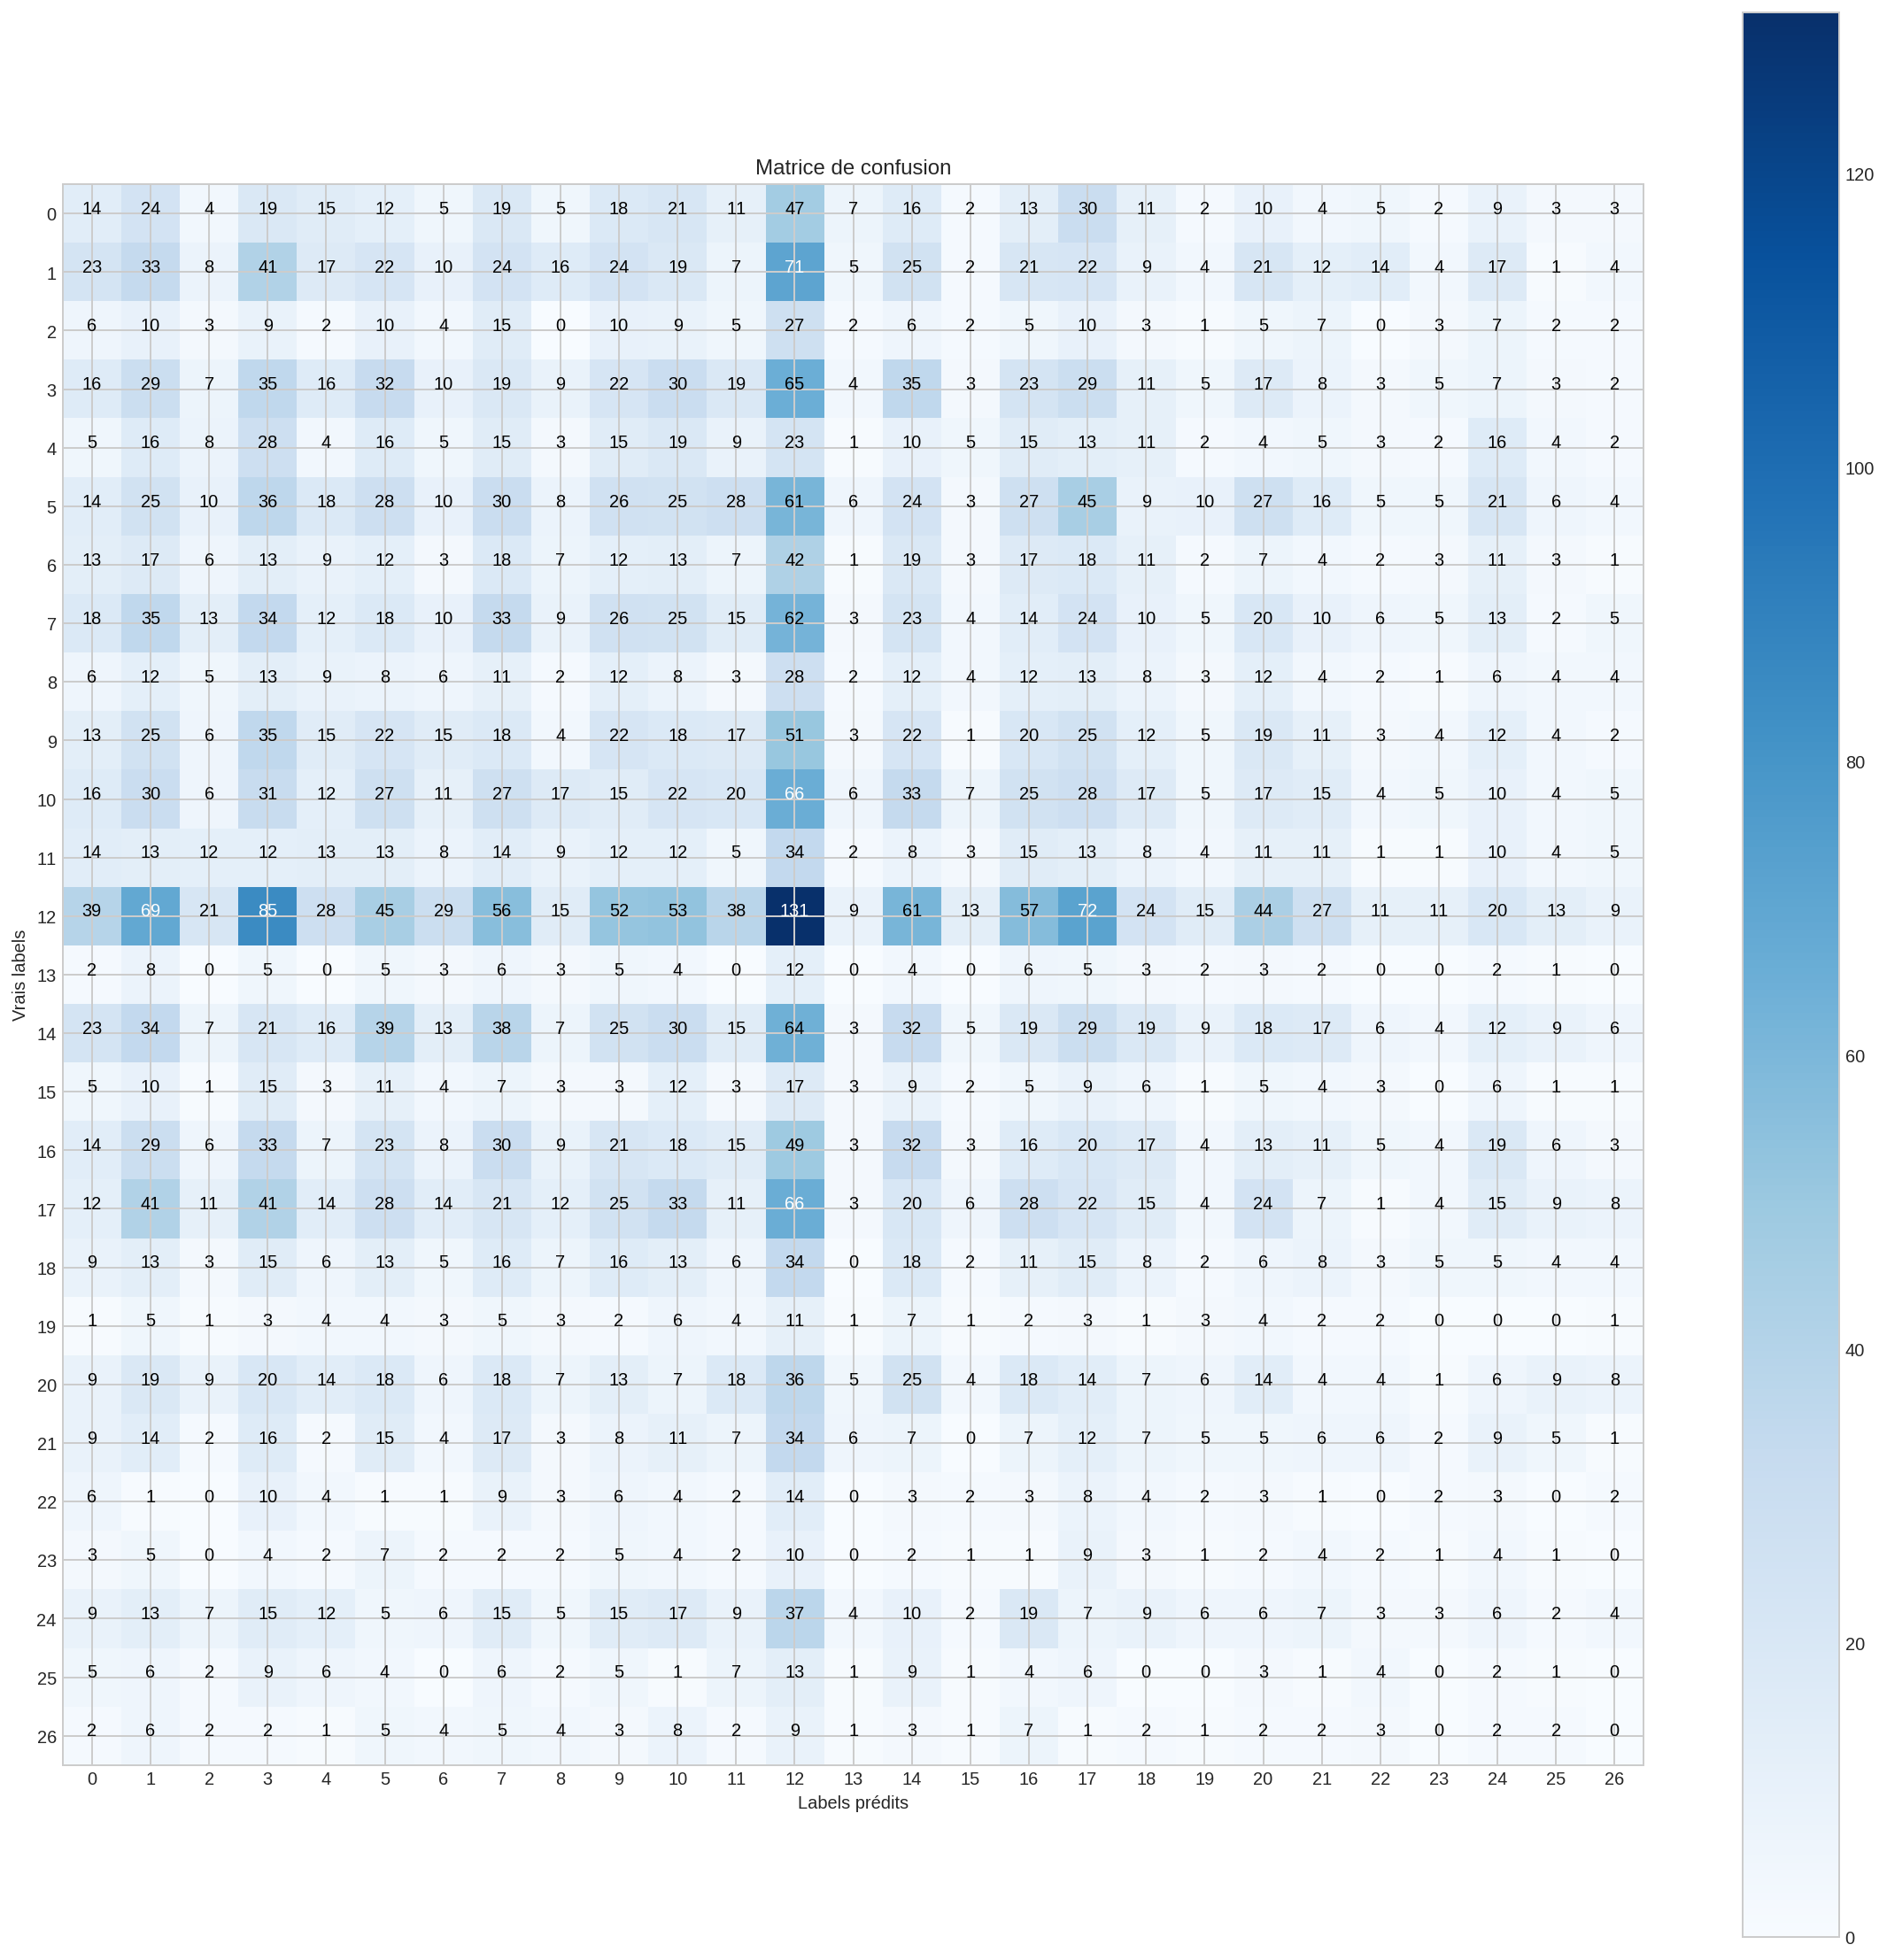

In [110]:
cm(y_test,test_pred_class)

In [111]:
cnf_matrix = metrics.confusion_matrix(y_test,test_pred_class)
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))

La classe 0 a souvent été prise pour la classe 1
La classe 0 a souvent été prise pour la classe 10
La classe 0 a souvent été prise pour la classe 12
La classe 0 a souvent été prise pour la classe 17
La classe 1 a souvent été prise pour la classe 0
La classe 1 a souvent été prise pour la classe 3
La classe 1 a souvent été prise pour la classe 5
La classe 1 a souvent été prise pour la classe 7
La classe 1 a souvent été prise pour la classe 9
La classe 1 a souvent été prise pour la classe 12
La classe 1 a souvent été prise pour la classe 14
La classe 1 a souvent été prise pour la classe 16
La classe 1 a souvent été prise pour la classe 17
La classe 1 a souvent été prise pour la classe 20
La classe 2 a souvent été prise pour la classe 12
La classe 3 a souvent été prise pour la classe 1
La classe 3 a souvent été prise pour la classe 5
La classe 3 a souvent été prise pour la classe 9
La classe 3 a souvent été prise pour la classe 10
La classe 3 a souvent été prise pour la classe 12
La classe



> Malgré des scores de performances élevés comparés au modèles unimodaux , ce modèle a appris à prédire uniquement la classe majoriatire, et obtient un taux d'erreurs élevés sur les autres classes 



## II.5. Résulat du Dual Encoder [Xception ,Bert]

L'entrainement de ce modèle s'est arrété au bout de 5 épochs seulement avec un F1 score de 56% sur les données train, et 55% sur les données val

Evaluation sur les données test

In [ ]:
dual_encoder.evaluate(test_dataset)

133/133 [==============================] - 67s 492ms/step - loss: 0.5943 - accuracy: 0.5845 - f1_score: 0.5439


[0.5942952036857605, 0.5845012068748474, 0.5438765287399292]

In [ ]:

test_pred_class = np.argmax(y,axis = 1)



In [ ]:
y_test_class=[]
for record in test_dataset:
  labels=record["label"]
  y_test=np.argmax(labels.numpy(),axis = 1)
  y_test_class.append(y_test)

y_test  = [val for sublist in y_test_class for val in sublist]
y_test=np.asarray(y_test)
 



> Matrice de confusion



In [ ]:
from sklearn import metrics
import itertools
def cm(y_test,test_pred):

  cnf_matrix = metrics.confusion_matrix(y_test, test_pred)

  ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
  classes = range(0,27)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

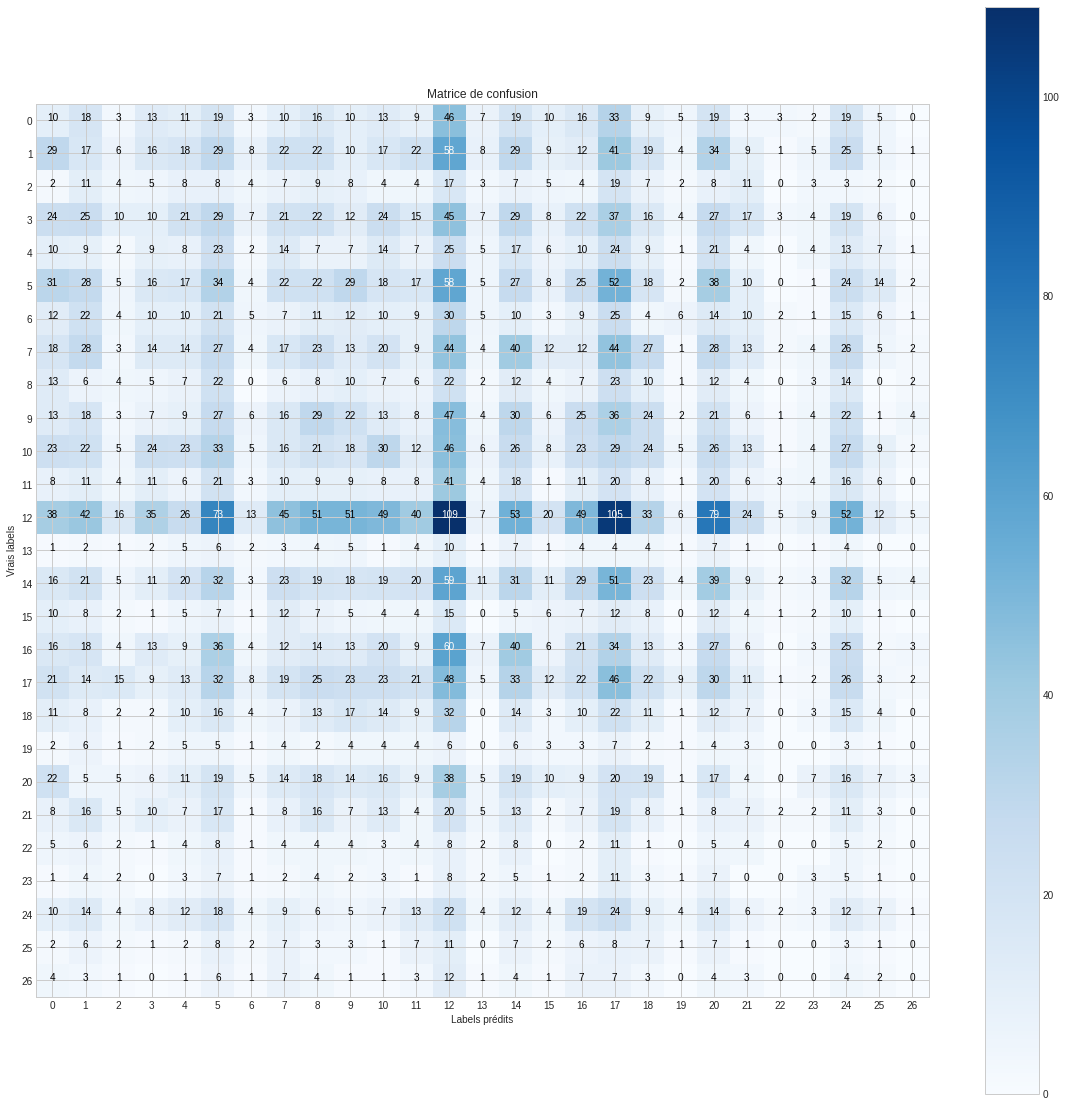

In [ ]:
cm(y_test,test_pred_class)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test,test_pred_class)
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))

La classe 0 a souvent été prise pour la classe 12
La classe 0 a souvent été prise pour la classe 17
La classe 1 a souvent été prise pour la classe 0
La classe 1 a souvent été prise pour la classe 5
La classe 1 a souvent été prise pour la classe 7
La classe 1 a souvent été prise pour la classe 8
La classe 1 a souvent été prise pour la classe 11
La classe 1 a souvent été prise pour la classe 12
La classe 1 a souvent été prise pour la classe 14
La classe 1 a souvent été prise pour la classe 17
La classe 1 a souvent été prise pour la classe 20
La classe 1 a souvent été prise pour la classe 24
La classe 3 a souvent été prise pour la classe 0
La classe 3 a souvent été prise pour la classe 1
La classe 3 a souvent été prise pour la classe 4
La classe 3 a souvent été prise pour la classe 5
La classe 3 a souvent été prise pour la classe 7
La classe 3 a souvent été prise pour la classe 8
La classe 3 a souvent été prise pour la classe 10
La classe 3 a souvent été prise pour la classe 12
La classe 



> le modèles n'est pas performant , prédiction quasi aléatoire puisque'il se trompe y compris pour la classe majortaire




## Pistes d'amélioration :
1. Entrainement sur les données rééquilibrées 
2. Utiliser une représentation du text plus intelligente comme Glove ? 
3. Utiliser du transfert Text learning à partir du modèle Camembert version française de Bert.
4. Continuer d'entrainer ce modèle comme la loss n'a pas arreté de baisser à la fin des 20 epoch.
5. Utiliser d'autres optimizers  

In [ ]:

dual_encoder.save("/models/multi_modal_model",save_format="tf")

INFO:tensorflow:Assets written to: /models/multi_modal_model/assets


INFO:tensorflow:Assets written to: /models/multi_modal_model/assets
